# Технологии искусственного интеллекта. Семестр 1

© Петров М.В., старший преподаватель кафедры суперкомпьютеров и общей информатики, Самарский университет

## Лекция 5. Линейная регрессия

### Содержание

1. [Введение](#5.1-Введение)
2. [Метод наименьших квадратов ($\textit{Ordinary Least Squares}$, $OLS$) МНК](#5.2-Метод-наименьших-квадратов-($\textit{Ordinary-Least-Squares}$,-$OLS$)-МНК)
3. [$Ridge$ регрессия](#5.3-$\textit{Ridge}$-регрессия)
4. [$LASSO$ регрессия](#5.4-$LASSO$-регрессия)
5. [$\textit{Elastic Net}$ регрессия](#5.5-$\textit{Elastic-Net}$-регрессия)
6. [Метрики качества линейных регрессионных моделей](#5.6-Метрики-качества-линейных-регрессионных-моделей)
7. [Пример](#5.7-Пример)
8. [Датасет `Rain in Australia`](#5.8-Датасет-Rain-in-Australia)
9. [Подготовка данных](#5.9-Подготовка-данных)
10. [Линейная регрессия для `Rain in Australia`](#5.10-Линейная-регрессия-для-Rain-in-Australia)
11. [Recursive Feature Elimination (RFE)](#5.11-Recursive-Feature-Elimination-(RFE))

### 5.1 Введение

Источники:
 - [Открытый курс машинного обучения. Тема 4. Линейные модели классификации и регрессии @ Хабр](https://habr.com/ru/companies/ods/articles/323890/)
 - [Знакомьтесь, линейные модели @ Хабр](https://habr.com/ru/articles/278513/)
 - [Линейные модели @ scikit-learn.ru](https://scikit-learn.ru/1-1-linear-models/)
 - [Linear Models @ scikit-learn](https://scikit-learn.org/stable/modules/linear_model.html)

Пусть дан набор из $M$ пар исходных данных $(X_i, Y_i)$, где  
$
\quad \begin{matrix*}[l]
X_i \in \mathbb{R}^D \\
Y_i \in \mathbb{R}^K \\
M,D,K \in \mathbb{N} \\
i = \overline{1, M} \\
\mathbb{R} \textit{ - множество вещественных чисел} \\
\mathbb{N} \textit{ - множество натуральных чисел}
\end{matrix*}
$  
$X_i$ &ndash; это последовательность вещественных чисел длиной $D$ &ndash; независимые переменные (также называются *факторами* или *регрессорами*), $Y_i$ &ndash; это последовательность вещественных чисел длиной $K$ &ndash; зависимые переменные (также называются *объясняемыми переменными*).  
В самом простом случае $D = K = 1$, то есть нам заданы пары чисел, например, (рост человека, вес человека), или (объем детали, вес детали), или (время ожидания в очереди, признак ухода клиента).  
Чаще всего $D > 1$, а $K = 1$, то есть для каждого $Y$ даны несколько $X$, например, ((рост, возраст), вес) или ((продажи вчера, продажи позавчера, продажи позапозавчера), продажи сегодня).  
Мы вдруг делаем неожиданное предположение: наши $Y$ не просто зависят, а *линейно* зависят от $X$, то есть $$Y = W^TX,$$ где $W$ &ndash; это параметры модели в виде вещественной матрицы размерности $D \times K$.  

Однако сразу же вспомним про два важных аспекта. Во-первых, нет никаких причин, чтобы $W^TX$ вот так вот строго равнялось $Y$. Ведь и исходные данные мы могли измерить (и скорее всего измерили) с погрешностью. Кроме того, возможно (и даже скорее всего почти точно) мы упустили из виду какие-то факторы $X$, которые тоже влияют на $Y$. Поэтому в модели надо учесть случайную ошибку. 
Во-вторых, нет никакой гарантии, что $Y$ линейно зависят сразу напрямую от $X$. Ведь возможно они зависят от чего-то другого, что в свою очередь зависит от $X$. Например, $Y$ может быть равен $W^T \cdot X^2$ или $W^T \cdot \log X$. А тогда почему, собственно, мы жаждем именно зависимости самого $Y$, а не какого-то значения, зависящего от $Y$, допустим, $\log Y = W^TX$.  

Таким образом мы приходим к обобщенной постановке линейной задачи:
$$
\begin{matrix*}[l]
Y^* = W^TX^* + \Xi, \\
X^* = f(X), \\
Y^* = g(Y), \\
\Xi \textit{ - случайная величина}.
\end{matrix*}
$$  

Несмотря на то, что $f$ и $g$ могут быть нелинейными функциями, и $Y$ в результате может весьма нелинейно зависеть от $X$, модель все равно остается линейной относительно параметров $W$. Именно поэтому она и называется линейной моделью.  
Из-за случайностей мы не можем легко рассчитать искомые коэффициенты $W$ нашей модели. Поэтому придется решить оптимизационную задачу вида 
$$\hat{W} = argmin \; F(W \mid X^*,Y^*),$$
где $F$ &ndash; некий функционал.  

> При $K = 1$:
> $$
\begin{matrix*}[l]
y^* = w^TX^* + \xi, \\
X^* = f(X), \\
y^* = g(y), \\
\xi \textit{ - случайная величина}. \\
\\
\hat{w} = argmin \; F(w \mid X^*,y^*).
\end{matrix*}
$$

Пусть далее для простоты $K = 1$. Можем выписать выражение для каждого конкретного наблюдения:

$$y_i = \displaystyle \sum_{j = 0}^{D} w_j \cdot X_{ij} + \xi_i, \quad i = \overline{1, M}.$$

Также на модель накладываются следующие ограничения (иначе это будет какая то другая регрессия, но точно не линейная):
- матожидание случайных ошибок равно нулю: $\forall i : \mathbb{E}[\xi_i] = 0$;
- дисперсия случайных ошибок одинакова и конечна: $\forall i : D[\xi_i] = \sigma^2 < \infty$;
- случайные ошибки не скоррелированы: $\forall i \neg j : cov(\xi_i, \xi_j) = 0$.

### 5.2 Метод наименьших квадратов ($\textit{Ordinary Least Squares}$, $OLS$) МНК

Один из способов вычислить значения параметров модели является метод наименьших квадратов (МНК), который минимизирует среднеквадратичную ошибку между реальным значением зависимой переменной и прогнозом, выданным моделью:
$$\min_w \|Xw-y\|_2^2.$$

Пример:

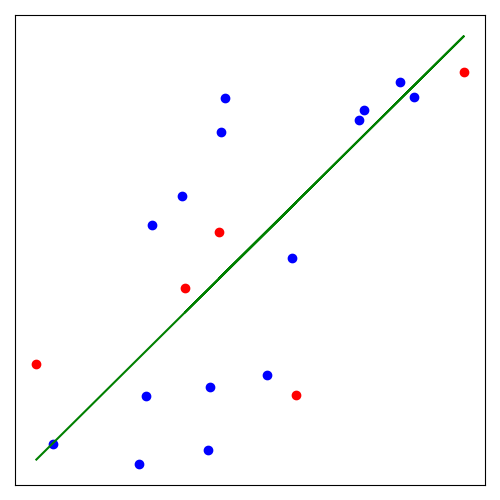

In [1]:
%matplotlib inline
%matplotlib widget
from ipywidgets import *
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# Генерируем данные для X и y
X, y = make_regression(n_samples=20, noise=10, n_features=1, random_state=0)

# Разделение данных на train и test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=3)

# Создание объекта класса линейной регрессии
regr = linear_model.LinearRegression()

# Обучение
regr.fit(train_X, train_y)

y_pred = regr.predict(test_X)

fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(train_X, train_y, color="blue")
plt.scatter(test_X, test_y, color="red")
plt.plot(test_X, y_pred, color="green")

plt.xticks(())
plt.yticks(())
plt.tight_layout()
plt.show()

### 5.3 $\textit{Ridge}$ регрессия

Гребневая регрессия или ридж-регрессия (англ. $\textit{Ridge Regression}$) &ndash; один из методов понижения размерности. Применяется для борьбы с избыточностью данных, когда независимые переменные коррелируют друг с другом, вследствие чего проявляется неустойчивость оценок коэффициентов многомерной линейной регрессии. Мультиколлинеарность (англ. multicollinearity) &ndash; наличие линейной зависимости между независимыми переменными регрессионной модели. Различают полную коллинеарность и частичную или просто мультиколлинеарность &ndash; наличие сильной корреляции между независимыми переменными. Получаемое решение минимизирует следующий функционал:

$$\min_w \|Xw-y\|_2^2 + \alpha \|w\|_2^2,$$

где $\alpha > 0$ &ndash; параметр регуляризации.

Пример.

Alpha: 0.2, score: 0.25352781316449347
Alpha: 1.0, score: 0.33665766783570417
Alpha: 1.8, score: 0.39281846746906224
Alpha: 2.6, score: 0.43046513356863936
Alpha: 3.4, score: 0.4551645774520874


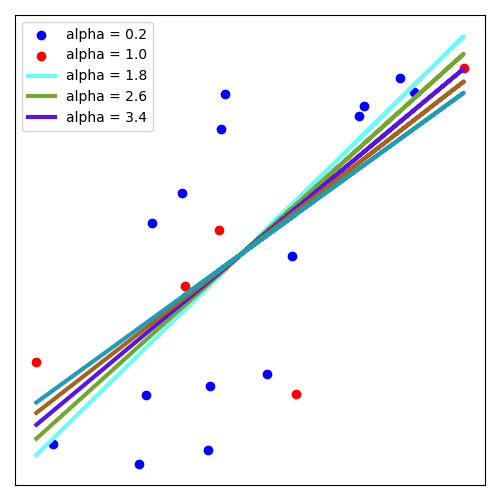

In [2]:
y_pred = []
labels = []

for a in np.arange(0.2, 4, 0.8):
    # Создание объекта класса Ridge регрессии
    ridge_regression = linear_model.Ridge(alpha=a)  # alpha - величина регуляризации
    # Обучение
    ridge_regression.fit(train_X, train_y)
    # Предсказание результата
    y_pred.append(ridge_regression.predict(test_X))
    # Вывод коэффициента детерминации
    print(f"Alpha: {a:.1f}, score: {ridge_regression.score(test_X, test_y)}")
    labels.append(f'alpha = {a:.1f}')

fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(train_X, train_y, color="blue")
plt.scatter(test_X, test_y, color="red")
for y in y_pred:
    plt.plot(test_X, y, color=np.random.rand(3,), linewidth=3)

ax.legend(labels)

plt.xticks(())
plt.yticks(())
plt.tight_layout()
plt.show()

### 5.4 $LASSO$ регрессия

Метод регрессии лассо (англ. $LASSO$, *Least Absolute Shrinkage and Selection Operator*) похож на гребневую регрессию, но он использует другое ограничение на коэффициенты:

$$\min_w \frac{1}{2M} \|Xw-y\|_2^2 + \alpha \|w\|_1,$$

где $\alpha > 0$ &ndash; параметр регуляризации.

Пример.

Alpha: 0.2, score: 0.26220692345462093
Alpha: 1.0, score: 0.376838744024913
Alpha: 1.8, score: 0.4503631386996726
Alpha: 2.6, score: 0.48278010747890043
Alpha: 3.4, score: 0.474089650362596


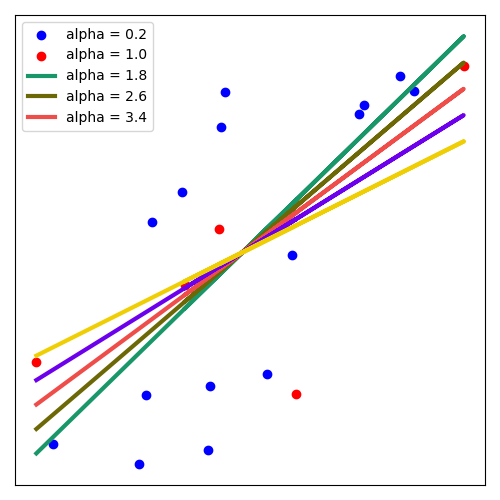

In [3]:
y_pred = []
labels = []

for a in np.arange(0.2, 4, 0.8):
    # Создание объекта класса LASSO регрессии
    lasso_regression = linear_model.Lasso(alpha=a)  # alpha — величина регуляризации
    # Обучение
    lasso_regression.fit(train_X, train_y)
    # Предсказание результата
    y_pred.append(lasso_regression.predict(test_X))
    # Вывод коэффициента детерминации
    print(f"Alpha: {a:.1f}, score: {lasso_regression.score(test_X, test_y)}")
    labels.append(f'alpha = {a:.1f}')

fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(train_X, train_y, color="blue")
plt.scatter(test_X, test_y, color="red")
for y in y_pred:
    plt.plot(test_X, y, color=np.random.rand(3,), linewidth=3)

ax.legend(labels)

plt.xticks(())
plt.yticks(())
plt.tight_layout()
plt.show()

### 5.5 $\textit{Elastic Net}$ регрессия

Эластичная сеть (англ. $\textit{Elastic Net}$):

$$\min_w \frac{1}{2M} \|Xw-y\|_2^2 + \alpha \rho \|w\|_1 + \frac{\alpha (1 - \rho)}{2} \|w\|_2^2,$$

где $\alpha > 0$ и $0 < \rho < 1$ &ndash; параметры регуляризации. При $\rho = 1$ мы получаем $LASSO$.

Пример.

{'alpha': 0.2, 'l1_ratio': 0.75}
Alpha: 0.2, l1_ratio: 0.25, score: 0.4195605305209349
Alpha: 0.2, l1_ratio: 0.50, score: 0.38424922600375966
Alpha: 0.2, l1_ratio: 0.75, score: 0.33393333847422046
Alpha: 1.0, l1_ratio: 0.25, score: 0.4479810943804682
Alpha: 1.0, l1_ratio: 0.50, score: 0.4750449163086159
Alpha: 1.0, l1_ratio: 0.75, score: 0.4817482598578643
Alpha: 1.8, l1_ratio: 0.25, score: 0.35376184896868756
Alpha: 1.8, l1_ratio: 0.50, score: 0.4008271437547779
Alpha: 1.8, l1_ratio: 0.75, score: 0.46061557238469697
Alpha: 2.6, l1_ratio: 0.25, score: 0.280550316390199
Alpha: 2.6, l1_ratio: 0.50, score: 0.32438651871768864
Alpha: 2.6, l1_ratio: 0.75, score: 0.3975667814926338
Alpha: 3.4, l1_ratio: 0.25, score: 0.2271837705288613
Alpha: 3.4, l1_ratio: 0.50, score: 0.2613995789824747
Alpha: 3.4, l1_ratio: 0.75, score: 0.3274831068727061


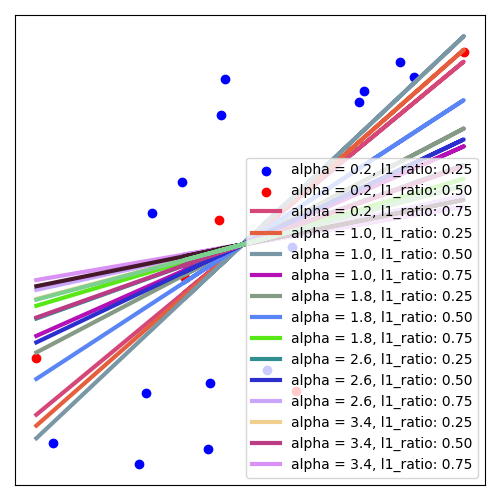

In [4]:
y_pred = []
labels = []

from sklearn.model_selection import GridSearchCV

parameters = {'alpha': np.arange(0.2, 4, 0.8), 'l1_ratio': [0.25, 0.5, 0.75]}
elastic_net = linear_model.ElasticNet()

grid_search = GridSearchCV(elastic_net, parameters)
grid_search.fit(train_X, train_y)

print(grid_search.best_params_)

for a in np.arange(0.2, 4, 0.8):
    for r in [0.25, 0.5, 0.75]:
        # Создание объекта класса Elastic Net регрессии
        elastic_net = linear_model.ElasticNet(alpha=a, l1_ratio=r)
        # Обучение
        elastic_net.fit(train_X, train_y)
        # Предсказание результата
        y_pred.append(elastic_net.predict(test_X))
        # Вывод коэффициента детерминации
        print(f"Alpha: {a:.1f}, l1_ratio: {r:.2f}, score: {elastic_net.score(test_X, test_y)}")
        labels.append(f'alpha = {a:.1f}, l1_ratio: {r:.2f}')

fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(train_X, train_y, color="blue")
plt.scatter(test_X, test_y, color="red")
for y in y_pred:
    plt.plot(test_X, y, color=np.random.rand(3,), linewidth=3)

ax.legend(labels)

plt.xticks(())
plt.yticks(())
plt.tight_layout()
plt.show()

### 5.6 Метрики качества линейных регрессионных моделей

Источники:
- [Оценка качества в задачах классификации и регрессии](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0%D1%85_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8)
- [Метрики](https://wiki.loginom.ru/metrics.html)
- [Метрики качества линейных регрессионных моделей](https://loginom.ru/blog/quality-metrics)

#### $MSE$

Средняя квадратичная ошибка (англ. $\textit{Mean Squared Error}$, $MSE$):

$$MSE = \displaystyle\frac{1}{M}\sum_{i = 1}^M (y_i - \hat{y_i})^2,$$
где $y_i$ &ndash; истинное значение целевого признака, $\hat{y_i}$ &ndash; предсказанное значение целевого признака.  

$MSE$ применяется в ситуациях, когда нам надо подчеркнуть большие ошибки и выбрать модель, которая дает меньше больших ошибок прогноза.

#### $MAE$

Cредняя абсолютная ошибка (англ. $\textit{Mean Absolute Error}$, $MAE$):

$$MAE = \displaystyle\frac{1}{M}\sum_{i = 1}^M |y_i - \hat{y_i}|,$$
где $y_i$ &ndash; истинное значение целевого признака, $\hat{y_i}$ &ndash; предсказанное значение целевого признака.  

Среднеквадратичный функционал $MSE$ сильнее штрафует за большие отклонения по сравнению со среднеабсолютным $MAE$, и поэтому более чувствителен к выбросам. При использовании любого из этих двух функционалов может быть полезно проанализировать, какие объекты вносят наибольший вклад в общую ошибку &ndash; не исключено, что на этих объектах была допущена ошибка при вычислении признаков или целевой величины.

Среднеквадратичная ошибка подходит для сравнения двух моделей или для контроля качества во время обучения, но не позволяет сделать выводов о том, на сколько хорошо данная модель решает задачу. Например, $MSE = 10$ является очень плохим показателем, если целевая переменная принимает значения от $0$ до $1$, и очень хорошим, если целевая переменная лежит в интервале $(10000, 100000)$. В таких ситуациях вместо среднеквадратичной ошибки полезно использовать коэффициент детерминации &ndash; $R^2$.

#### $R^2$

Коэффициент детерминации $R^2$:

$$R^2 = \displaystyle 1 - \frac{\displaystyle\sum_{i = 1}^M (y_i - \hat{y_i})^2}{\displaystyle\sum_{i = 1}^M (y_i - \overline{y})^2},$$
где $y_i$ &ndash; истинное значение целевого признака, $\hat{y_i}$ &ndash; предсказанное значение целевого признака, $\overline{y}$ &ndash; среднее значение целевого признака.  

Коэффициент детерминации является статистической мерой согласия, с помощью которой можно определить, насколько модель линейной регрессии соответствует данным, на которых она построена. Коэффициент детерминации изменяется в диапазоне от $-\infty$ до $1$. Если он равен $1$, это соответствует идеальной модели, когда все точки наблюдений лежат точно на линии регрессии, т.е. сумма квадратов их отклонений равна $0$. Если коэффициент детерминации равен $0$, это означает, что связь между переменными регрессионной модели отсутствует, и вместо нее для оценки значения выходной переменной можно использовать простое среднее ее наблюдаемых значений.  
На практике, если коэффициент детерминации близок к $1$, это указывает на то, что модель работает очень хорошо (имеет высокую значимость), а если к $0$, то это означает низкую значимость модели, когда входная переменная плохо «объясняет» поведение выходной, т.е. линейная зависимость между ними отсутствует. Очевидно, что такая модель будет иметь низкую эффективность.  
Кроме того, бывают случаи, когда коэффициент детерминации принимает отрицательные значения (обычно небольшие). Это случается, когда ошибка модели простого среднего становится меньше ошибки регрессионной модели. Таким образом, добавление в модель с константой некоторой переменной только ухудшает её.

#### Скорректированный $R^2$

Основной проблемой при использовании коэффициента детерминации является то, что он увеличивается (или, по крайней мере, не уменьшается) при добавлении в модель новых переменных, даже если эти переменные никак не связаны с зависимой переменной.  
В связи с этим возникают две проблемы. Первая заключается в том, что не все переменные, добавляемые в модель, могут значимо увеличивать её точность, но при этом всегда увеличивают её сложность. Вторая проблема &ndash; с помощью коэффициента детерминации нельзя сравнивать модели с разным числом переменных. Чтобы преодолеть эти проблемы используют альтернативные показатели, одним из которых является скорректированный коэффициент детерминации англ. ($\textit{Adjasted coefficient of determination}$).  
Скорректированный коэффициент детерминации даёт возможность сравнивать модели с разным числом переменных так, чтобы их число не влияло на статистику $R^2$, и накладывает штраф за дополнительно включённые в модель переменные. Вычисляется по формуле:

$$R_{adj}^2 = \displaystyle 1 - \frac{\displaystyle\sum_{i = 1}^M\frac{(y_i - \hat{y_i})^2}{M - D}}{\displaystyle\sum_{i = 1}^M\frac{(y_i - \overline{y})^2}{M - 1}},$$
где $y_i$ &ndash; истинное значение целевого признака, $\hat{y_i}$ &ndash; предсказанное значение целевого признака, $\overline{y}$ &ndash; среднее значение целевого признака, $M$ &ndash; число наблюдений, $D$ &ndash; количество переменных в модели. 

#### $MAPE$

Средняя абсолютная процентная ошибка (англ. $\textit{Mean Absolute Percentage Error}$, $MAPE$):

$$MAPE = 100\% \cdot \displaystyle\frac{1}{M} \sum_{i = 1}^M \frac{|y_i - \hat{y_i}|}{|y_i|},$$
где $y_i$ &ndash; истинное значение целевого признака, $\hat{y_i}$ &ndash; предсказанное значение целевого признака.  

Это коэффициент, не имеющий размерности, с очень простой интерпретацией. Его можно измерять в долях или процентах. Если у вас получилось, например, что $MAPE = 11.4\%$, то это говорит о том, что ошибка составила $11,4\%$ от фактических значений. Основная проблема данной ошибки &ndash; нестабильность.

#### $RMSE$

Корень из средней квадратичной ошибки (англ. $\textit{Root Mean Squared Error}$, $RMSE$):

$$RMSE = \sqrt{\displaystyle\frac{1}{M}\sum_{i = 1}^M (y_i - \hat{y_i})^2},$$
где $y_i$ &ndash; истинное значение целевого признака, $\hat{y_i}$ &ndash; предсказанное значение целевого признака.  

Примерно такая же проблема, как и в $MAPE$: так как каждое отклонение возводится в квадрат, любое небольшое отклонение может значительно повлиять на показатель ошибки.

#### $SMAPE$

Cимметричная cредняя абсолютная процентная ошибка (англ. $\textit{Symmetric MAPE}$, $SMAPE$):

$$SMAPE = 100\% \cdot \displaystyle\frac{1}{M} \sum_{i = 1}^M \frac{|y_i - \hat{y_i}|}{\frac{|y_i| + |\hat{y_i}|}{2}} = 100\% \cdot \displaystyle\frac{1}{M} \sum_{i = 1}^M \frac{2 \cdot |y_i - \hat{y_i}|}{|y_i| + |\hat{y_i}|} = 200\% \cdot \displaystyle\frac{1}{M} \sum_{i = 1}^M \frac{|y_i - \hat{y_i}|}{|y_i| + |\hat{y_i}|},$$
где $y_i$ &ndash; истинное значение целевого признака, $\hat{y_i}$ &ndash; предсказанное значение целевого признака.  

Т.е. абсолютная разность между наблюдаемым и предсказанным значениями делится на полусумму их модулей. В отличие от обычной $MAPE$, симметричная имеет ограничение на диапазон значений. В приведённой формуле он составляет от $0$ до $200\%$. Однако, поскольку диапазон от $0$ до $100\%$ гораздо удобнее интерпретировать, часто используют формулу, где отсутствует деление знаменателя на $2$.

Одной из возможных проблем $SMAPE$ является неполная симметрия, поскольку в разных диапазонах ошибка вычисляется неодинаково. Это иллюстрируется следующим примером: если $y_i = 100$ и $\hat{y_i} = 110$, то $SMAPE = 4.76$, а если $y_i = 100$ и $\hat{y_i} = 90$, то $SMAPE = 5.26$. Ограничение $SMAPE$ заключается в том, что, если наблюдаемое или предсказанное значение равно $0$, ошибка резко возрастет до верхнего предела ($200\%$ или $100\%$).

#### $MSPE$

Среднеквадратичная ошибка в процентах (англ. $\textit{Mean Squared Percentage Error}$, $MSPE$) представляет собой относительную ошибку, где разность между наблюдаемым и фактическим значениями делится на наблюдаемое значение и выражается в процентах:

$$MSPE = \displaystyle\frac{100\%}{M}\sum_{i = 1}^M \left(\frac{y_i - \hat{y_i}}{y_i}\right)^2,$$
где $y_i$ &ndash; истинное значение целевого признака, $\hat{y_i}$ &ndash; предсказанное значение целевого признака.  

Проблемой при использовании $MSPE$ является то, что, если наблюдаемое значение выходной переменной равно $0$, значение ошибки становится неопределённым. $MSPE$ можно рассматривать как взвешенную версию $MSE$, где вес обратно пропорционален квадрату наблюдаемого значения. Таким образом, при возрастании наблюдаемых значений ошибка имеет тенденцию уменьшаться.

#### $MASE$

Средняя абсолютная масштабированная ошибка (англ. $\textit{Mean Absolute Scaled Error}$, $MASE$) &ndash; это показатель, который позволяет сравнивать две модели. Если поместить $MAE$ для новой модели в числитель, а $MAE$ для исходной модели в знаменатель, то полученное отношение и будет равно $MASE$. Если значение $MASE$ меньше $1$, то новая модель работает лучше, если $MASE$ равно $1$, то модели работают одинаково, а если значение $MASE$ больше $1$, то исходная модель работает лучше, чем новая модель. Формула для расчета $MASE$ имеет вид:

$$MASE = \displaystyle\frac{MAE_i}{MAE_j}.$$

$MASE$ симметрична и устойчива к выбросам.

#### $MRE$

Средняя относительная ошибка (англ. $\textit{Mean Relative Error}$, $MRE$) вычисляется по формуле:
$$MRE = \displaystyle\frac{1}{M}\sum_{i = 1}^M \frac{|y_i - \hat{y_i}|}{|y_i|},$$
где $y_i$ &ndash; истинное значение целевого признака, $\hat{y_i}$ &ndash; предсказанное значение целевого признака.  

Несложно увидеть, что данная мера показывает величину абсолютной ошибки относительно фактического значения выходной переменной (поэтому иногда эту ошибку называют также средней относительной абсолютной ошибкой, $MRAE$). Действительно, если значение абсолютной ошибки, скажем, равно $10$, то сложно сказать много это или мало. Например, относительно значения выходной переменной, равного $20$, это составляет $50\%$, что достаточно много. Однако относительно значения выходной переменной, равного $100$, это будет уже $10\%$, что является вполне нормальным результатом.  
Очевидно, что при вычислении $MRE$ нельзя применять наблюдения, в которых $y_i = 0$.  
Таким образом, $MRE$ позволяет более адекватно оценить величину ошибки, чем абсолютные ошибки. Кроме этого она является безразмерной величиной, что упрощает интерпретацию.

#### $RMSLE$

Среднеквадратичная логарифмическая ошибка (англ. $\textit{Root Mean Squared Logarithmic Error}$, $RMSLE$) представляет собой $RMSE$, вычисленную в логарифмическом масштабе:

$$RMSLE = \sqrt{\displaystyle\frac{1}{M}\sum_{i = 1}^M \left(log(\hat{y_i} + 1) - log(y_i + 1)\right)^2},$$
где $y_i$ &ndash; истинное значение целевого признака, $\hat{y_i}$ &ndash; предсказанное значение целевого признака.  

Константы, равные 1, добавляемые в скобках, необходимы чтобы не допустить обращения в 0 выражения под логарифмом, поскольку логарифм нуля не существует.  
Известно, что логарифмирование приводит к сжатию исходного диапазона изменения значений переменной. Поэтому применение $RMSLE$ целесообразно, если предсказанное и фактическое значения выходной переменной различаются на порядок и больше.

#### Сравнение метрик

| Метрика     | Сильные стороны                                                                                                                                                                                   | Слабые стороны                                                                                                                                                                   |
|-------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| $MSE$       | Позволяет подчеркнуть большие отклонения, простота вычисления.                                                                                                                                    | Имеет тенденцию занижать качество модели, чувствительна к выбросам. Сложность интерпретации из-за квадратичной зависимости.                                                      |
| $RMSE$      | Простота интерпретации, поскольку измеряется в тех же единицах, что и целевая переменная.                                                                                                         | Имеет тенденцию занижать качество модели, чувствительна к выбросам.                                                                                                              |
| $MSPE$      | Нечувствительна к выбросам. Хорошо интерпретируема, поскольку имеет линейный характер.                                                                                                            | Поскольку вклад всех ошибок отдельных наблюдений взвешивается одинаково, не позволяет подчёркивать большие и малые ошибки.                                                       |
| $MAPE$      | Является безразмерной величиной, поэтому её интерпретация не зависит от предметной области.                                                                                                       | Нельзя использовать для наблюдений, в которых значения выходной переменной равны нулю.                                                                                           |
| $SMAPE$     | Позволяет корректно работать с предсказанными значениями независимо от того больше они фактического, или меньше.                                                                                  | Приближение к нулю фактического или предсказанного значения приводит к резкому росту ошибки, поскольку в знаменателе присутствует как фактическое, так и предсказанное значения. |
| $MASE$      | Не зависит от масштаба данных, является симметричной: положительные и отрицательные отклонения от фактического значения учитываются одинаково. Устойчива к выбросам. Позволяет сравнивать модели. | Сложность интерпретации.                                                                                                                                                         |
| $MRE$       | Позволяет оценить величину ошибки относительно значения целевой переменной.                                                                                                                       | Неприменима для наблюдений с нулевым значением выходной переменной.                                                                                                              |
| $RMSLE$     | Логарифмирование позволяет сделать величину ошибки более устойчивой, когда разность между фактическим и предсказанным значениями различается на порядок и выше                                    | Может быть затруднена интерпретация из-за нелинейности.                                                                                                                          |
| $R^2$       | Универсальность, простота интерпретации.                                                                                                                                                          | Возрастает даже при включении в модель бесполезных переменных. Плохо работает когда входные переменные зависимы.                                                                 |
| $R_{adj}^2$ | Корректно отражает вклад каждой переменной в модель.                                                                                                                                              | Плохо работает, когда входные переменные зависимы.                                                                                                                               |

### 5.7 Пример

Задача: построить преобразование цвета в пространстве $RGB$. Имеются входные цвета &ndash; массив триплетов (троек) яркостей пиксела в каждом из $RGB$ каналов изображения, и выходные цвета.

In [5]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
# путь к папке с данными
data_path = "data"

with open(Path(data_path, 'chart_4096_colors.json')) as f:
    data = json.load(f)
colors = np.array(data['lut'])
colors_in, colors_out = np.hsplit(colors, 2)
colors_in, colors_out

(array([[  0,   1,   8],
        [  0,   1,  13],
        [  0,   2,  26],
        ...,
        [232, 232, 233],
        [231, 231, 232],
        [ 30,  31,  23]]),
 array([[  0,   0,   0],
        [  0,   0,  17],
        [  0,   0,  34],
        ...,
        [255, 255, 238],
        [255, 255, 255],
        [  0,   0,   0]]))

In [6]:
df = pd.DataFrame(colors)
df.columns = ['$R_{in}$', '$G_{in}$', '$B_{in}$', '$R_{out}$', '$G_{out}$', '$B_{out}$']
df

,$R_{in}$,$G_{in}$,$B_{in}$,$R_{out}$,$G_{out}$,$B_{out}$
0,0,1,8,0,0,0
1,0,1,13,0,0,17
2,0,2,26,0,0,34
3,1,3,42,0,0,51
4,2,6,67,0,0,68
...,...,...,...,...,...,...
4091,232,233,221,255,255,204
4092,232,232,232,255,255,221
4093,232,232,233,255,255,238
4094,231,231,232,255,255,255


In [7]:
df['$R_{in}$']

0         0
1         0
2         0
3         1
4         2
       ... 
4091    232
4092    232
4093    232
4094    231
4095     30
Name: $R_{in}$, Length: 4096, dtype: int32

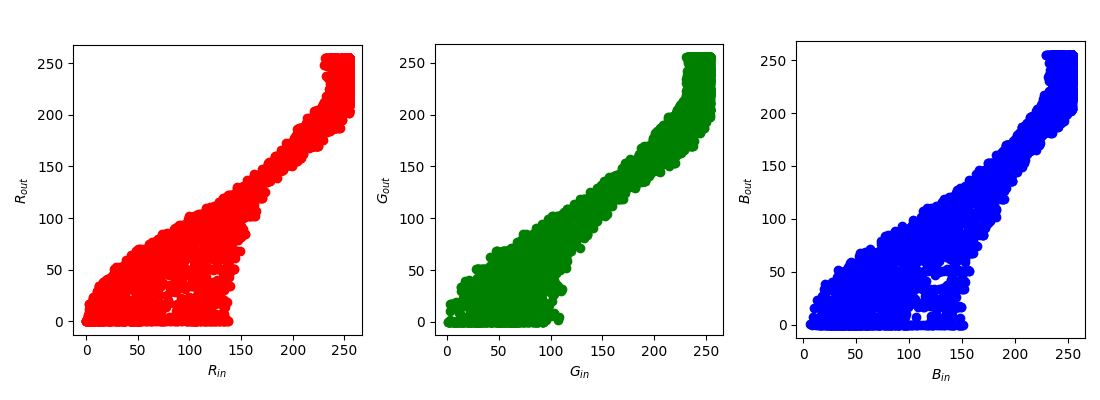

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(11, 4))

ax[0].scatter(df['$R_{in}$'], df['$R_{out}$'], color='red')
ax[1].scatter(df['$G_{in}$'], df['$G_{out}$'], color='green')
ax[2].scatter(df['$B_{in}$'], df['$B_{out}$'], color='blue')
for i, axis in enumerate(ax):
    axis.set_aspect('equal', adjustable='box')
    axis.set_xlabel(df.columns[i])
    axis.set_ylabel(df.columns[i + 3])
plt.tight_layout()
plt.show()

На графиках видно, что зависимость цвета в каждом цветовом канале имеет нелинейный характер. Поэтому сгенерируем дополнительные входные признаки, добавим полиномиальные члены:
$$
\begin{matrix*}[l]
r_{out} = \displaystyle\sum_{i = 0}^p w_i^R \cdot r_{in}^i = w_0^R \cdot 1 + w_1^R \cdot r_{in} + w_2^R \cdot r_{in}^2 + \dots + w_p^R \cdot r_{in}^p \\
g_{out} = \displaystyle\sum_{i = 0}^p w_i^G \cdot g_{in}^i = w_0^G \cdot 1 + w_1^G \cdot g_{in} + w_2^G \cdot g_{in}^2 + \dots + w_p^G \cdot g_{in}^p \\
b_{out} = \displaystyle\sum_{i = 0}^p w_i^B \cdot b_{in}^i = w_0^B \cdot 1 + w_1^B \cdot b_{in} + w_2^B \cdot b_{in}^2 + \dots + w_p^B \cdot b_{in}^p
\end{matrix*}
$$

То есть у нас есть 3 целевых признака ($R_{out}, G_{out}, B_{out}$) и набор входных признаков ($R_{in}, G_{in}, B_{in}$), дополненный сгенерированными признаками. Векторы коэффициентов наших полиномов $\overrightarrow{w^R}, \overrightarrow{w^G}, \overrightarrow{w^B}$ &ndash; искомые решения.

Для наглядности будем решать задачу только для одного цветового канала &ndash; красного:
$$
r_{out} = \displaystyle\sum_{i = 0}^p w_i^R \cdot r_{in}^i = w_0^R \cdot 1 + w_1^R \cdot r_{in} + w_2^R \cdot r_{in}^2 + \dots + w_p^R \cdot r_{in}^p
$$

In [9]:
df_ext = df.copy()
df_ext = df_ext.div(255.0)
df_ext

,$R_{in}$,$G_{in}$,$B_{in}$,$R_{out}$,$G_{out}$,$B_{out}$
0,0.000000,0.003922,0.031373,0.0,0.0,0.000000
1,0.000000,0.003922,0.050980,0.0,0.0,0.066667
2,0.000000,0.007843,0.101961,0.0,0.0,0.133333
3,0.003922,0.011765,0.164706,0.0,0.0,0.200000
4,0.007843,0.023529,0.262745,0.0,0.0,0.266667
...,...,...,...,...,...,...
4091,0.909804,0.913725,0.866667,1.0,1.0,0.800000
4092,0.909804,0.909804,0.909804,1.0,1.0,0.866667
4093,0.909804,0.909804,0.913725,1.0,1.0,0.933333
4094,0.905882,0.905882,0.909804,1.0,1.0,1.000000


Добавим в датафрейм единичный признак &ndash; вектор свободных членов:

In [10]:
df_ext['intercept'] = 1
df_ext

,$R_{in}$,$G_{in}$,$B_{in}$,$R_{out}$,$G_{out}$,$B_{out}$,intercept
0,0.000000,0.003922,0.031373,0.0,0.0,0.000000,1
1,0.000000,0.003922,0.050980,0.0,0.0,0.066667,1
2,0.000000,0.007843,0.101961,0.0,0.0,0.133333,1
3,0.003922,0.011765,0.164706,0.0,0.0,0.200000,1
4,0.007843,0.023529,0.262745,0.0,0.0,0.266667,1
...,...,...,...,...,...,...,...
4091,0.909804,0.913725,0.866667,1.0,1.0,0.800000,1
4092,0.909804,0.909804,0.909804,1.0,1.0,0.866667,1
4093,0.909804,0.909804,0.913725,1.0,1.0,0.933333,1
4094,0.905882,0.905882,0.909804,1.0,1.0,1.000000,1


Сгенерируем дополнительные признаки:

In [11]:
poly_deg = 3
pd_l = [p for p in range(2, poly_deg + 1)]
print(f'Polynomial degree list: {pd_l}')
for p in pd_l:
    df_ext[f'$R_{{in}}^{{{p}}}$'] = df_ext['$R_{in}$'].pow(p)
df_ext

Polynomial degree list: [2, 3]


,$R_{in}$,$G_{in}$,$B_{in}$,$R_{out}$,$G_{out}$,$B_{out}$,intercept,$R_{in}^{2}$,$R_{in}^{3}$
0,0.000000,0.003922,0.031373,0.0,0.0,0.000000,1,0.000000,0.000000e+00
1,0.000000,0.003922,0.050980,0.0,0.0,0.066667,1,0.000000,0.000000e+00
2,0.000000,0.007843,0.101961,0.0,0.0,0.133333,1,0.000000,0.000000e+00
3,0.003922,0.011765,0.164706,0.0,0.0,0.200000,1,0.000015,6.030863e-08
4,0.007843,0.023529,0.262745,0.0,0.0,0.266667,1,0.000062,4.824690e-07
...,...,...,...,...,...,...,...,...,...
4091,0.909804,0.913725,0.866667,1.0,1.0,0.800000,1,0.827743,7.530840e-01
4092,0.909804,0.909804,0.909804,1.0,1.0,0.866667,1,0.827743,7.530840e-01
4093,0.909804,0.909804,0.913725,1.0,1.0,0.933333,1,0.827743,7.530840e-01
4094,0.905882,0.905882,0.909804,1.0,1.0,1.000000,1,0.820623,7.433877e-01


In [12]:
df_ext.columns

Index(['$R_{in}$', '$G_{in}$', '$B_{in}$', '$R_{out}$', '$G_{out}$',
       '$B_{out}$', 'intercept', '$R_{in}^{2}$', '$R_{in}^{3}$'],
      dtype='object')

Сформируем список названий входных признаков: столбец свободных членов, $R_{in}$, $R_{in}^2$, $R_{in}^3$, отфильтруем датафрейм по списку признаков:

In [13]:
columns = ['intercept', '$R_{in}$']
for p in pd_l:
    columns.append(f'$R_{{in}}^{{{p}}}$')
X = df_ext[columns]
X

,intercept,$R_{in}$,$R_{in}^{2}$,$R_{in}^{3}$
0,1,0.000000,0.000000,0.000000e+00
1,1,0.000000,0.000000,0.000000e+00
2,1,0.000000,0.000000,0.000000e+00
3,1,0.003922,0.000015,6.030863e-08
4,1,0.007843,0.000062,4.824690e-07
...,...,...,...,...
4091,1,0.909804,0.827743,7.530840e-01
4092,1,0.909804,0.827743,7.530840e-01
4093,1,0.909804,0.827743,7.530840e-01
4094,1,0.905882,0.820623,7.433877e-01


Сформируем целевой признак:

In [14]:
y = df_ext['$R_{out}$']
y

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4091    1.0
4092    1.0
4093    1.0
4094    1.0
4095    0.0
Name: $R_{out}$, Length: 4096, dtype: float64

#### Линейная регрессия

In [15]:
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE, r2_score as R2
# Разделение данных на train и test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=42)

# Создаем объект линейного регрессора
regr = linear_model.LinearRegression()

# Обучаем
regr.fit(train_X, train_y)

# Получаем предсказание на тестовой выборке
y_pred = regr.predict(test_X)

max_len = 36
# Коэффициенты регрессии
print(f"{'Коэффициенты регрессии:':<{max_len}} {regr.coef_}")
# MSE
print(f"{'Средняя квадратичная ошибка (MSE):':<{max_len}} {MSE(test_y, y_pred):.3f}")
# MAE
print(f"{'Средняя абсолютная ошибка (MAE):':<{max_len}} {MAE(test_y, y_pred):.3f}")
# R2 score
print(f"{'Коэффициент детерминации (R2 score):':<{max_len}} {R2(test_y, y_pred):.3f}")

Коэффициенты регрессии:              [0.         0.29271075 0.57773171 0.01974938]
Средняя квадратичная ошибка (MSE):   0.009
Средняя абсолютная ошибка (MAE):     0.071
Коэффициент детерминации (R2 score): 0.914


In [16]:
train_X.columns.to_list()

['intercept', '$R_{in}$', '$R_{in}^{2}$', '$R_{in}^{3}$']

Рендер markdown ячейки, содержащий символы $\mathrm \LaTeX$, программно:

In [17]:
from IPython.display import display, Markdown, Latex
cols = train_X.columns.to_list()
cols[0] = '1'
s = f"Полученное решение: $R_{{out}} = "
for col, val in zip(cols, regr.coef_):
    s += f"{val} \cdot {col.strip('$')} +"
s = s[:-2]
s += "$"

display(Latex(s))

<IPython.core.display.Latex object>

Для построения кривой преобразования напишем вспомогательную функцию (дабы не плодить лишние данные, посчитаем сумму полиномиальных членов на лету):

In [18]:
def poly_eval(x_in, w_in, poly_deg):
    y_out = w_in[0] + w_in[1] * x_in
    for p in range(2, poly_deg + 1):
        y_out += w_in[p] * x_in ** p
    return y_out

In [19]:
x_in = np.array([x for x in range(256)]).reshape((-1, 1)) / 255.0
y_pred_out = poly_eval(x_in, regr.coef_, poly_deg)
# np.rint(np.hstack((x_in, y_pred_out)) * 255)

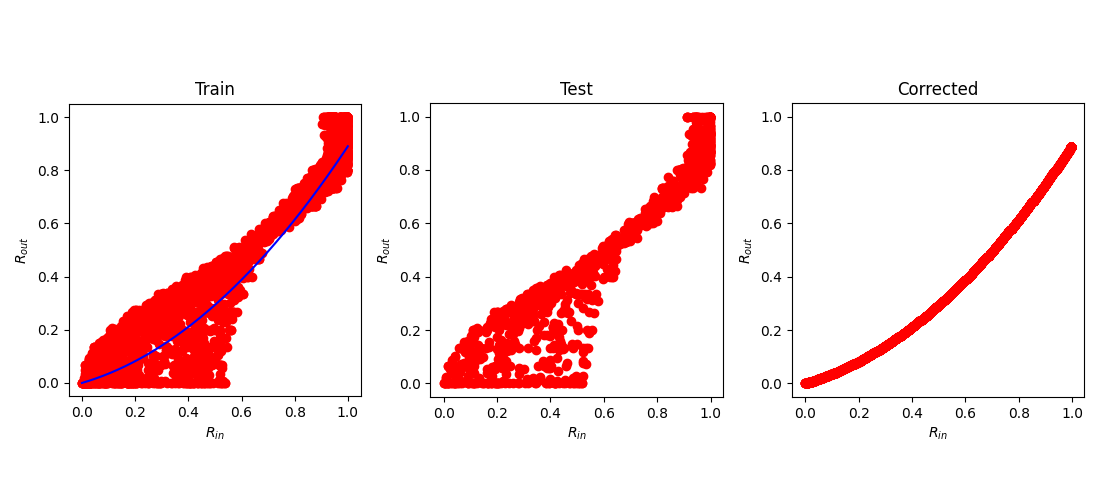

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(11, 5))

ax[0].scatter(train_X['$R_{in}$'], train_y, color='red')
ax[0].set_xlabel('$R_{in}$')
ax[0].set_ylabel('$R_{out}$')
ax[0].plot(x_in, y_pred_out, color='blue')
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_title('Train')

ax[1].scatter(test_X['$R_{in}$'], test_y, color='red')
ax[1].set_xlabel('$R_{in}$')
ax[1].set_ylabel('$R_{out}$')
ax[1].set_aspect('equal', adjustable='box')
ax[1].set_title('Test')

y_corr = poly_eval(X['$R_{in}$'].to_numpy(), regr.coef_, poly_deg)

ax[2].scatter(X['$R_{in}$'], y_corr, color='red')
ax[2].set_xlabel('$R_{in}$')
ax[2].set_ylabel('$R_{out}$')
ax[2].set_xlim(ax[1].get_xlim())
ax[2].set_ylim(ax[1].get_ylim())
ax[2].set_aspect('equal', adjustable='box')
ax[2].set_title('Corrected')

plt.tight_layout()
plt.show()

Объединим весь код в одну ячейку.

Коэффициенты регрессии:
[  0.           1.88040365  -8.60236228  20.73361684 -20.08939771
   7.03215809]
Средняя квадратичная ошибка (MSE):   0.009
Средняя абсолютная ошибка (MAE):     0.071
Коэффициент детерминации (R2 score): 0.916


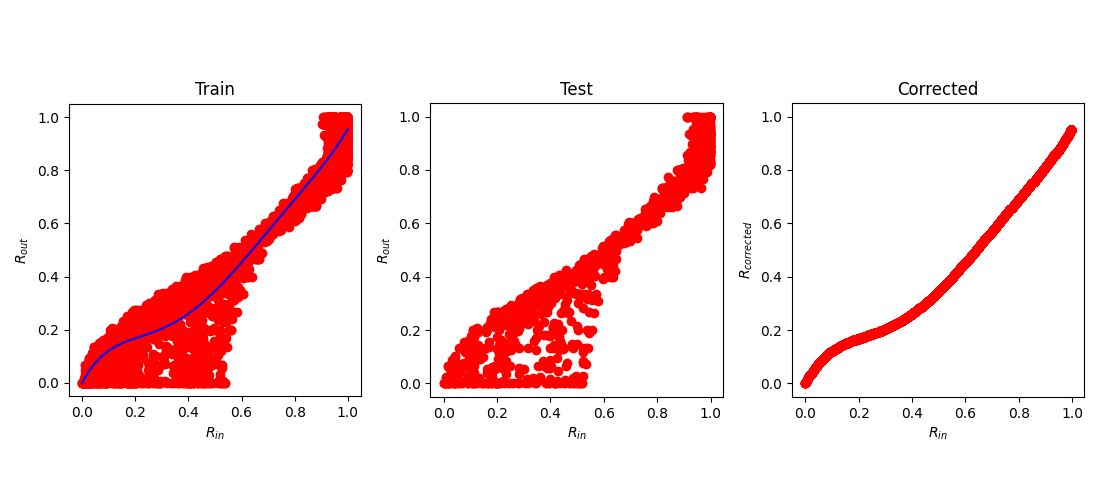

<IPython.core.display.Latex object>

In [23]:
poly_deg = 5

df_ext = df.copy()
df_ext = df_ext.div(255.0)
df_ext['intercept'] = 1

pd_l = [p for p in range(2, poly_deg + 1)]
for p in pd_l:
    df_ext[f'$R_{{in}}^{{{p}}}$'] = df_ext['$R_{in}$'].pow(p)

columns = ['intercept', '$R_{in}$']
for p in pd_l:
    columns.append(f'$R_{{in}}^{{{p}}}$')
X = df_ext[columns]
y = df_ext['$R_{out}$']

# разделение данных на train и test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_X, train_y)

y_pred = regr.predict(test_X)

max_len = 36
# Коэффициенты регрессии
print(f"Коэффициенты регрессии:\n{regr.coef_}")
# MSE
print(f"{'Средняя квадратичная ошибка (MSE):':<{max_len}} {MSE(test_y, y_pred):.3f}")
# MAE
print(f"{'Средняя абсолютная ошибка (MAE):':<{max_len}} {MAE(test_y, y_pred):.3f}")
# R2 score
print(f"{'Коэффициент детерминации (R2 score):':<{max_len}} {R2(test_y, y_pred):.3f}")

x_in = np.array([x for x in range(256)]).reshape((-1, 1)) / 255.0
y_pred_out = poly_eval(x_in, regr.coef_, poly_deg)

fig, ax = plt.subplots(1, 3, figsize=(11, 5))

ax[0].scatter(train_X['$R_{in}$'], train_y, color='red')
ax[0].set_xlabel('$R_{in}$')
ax[0].set_ylabel('$R_{out}$')
ax[0].plot(x_in, y_pred_out, color='blue')
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_title('Train')

ax[1].scatter(test_X['$R_{in}$'], test_y, color='red')
ax[1].set_xlabel('$R_{in}$')
ax[1].set_ylabel('$R_{out}$')
ax[1].set_aspect('equal', adjustable='box')
ax[1].set_title('Test')

y_corr = poly_eval(X['$R_{in}$'].to_numpy(), regr.coef_, poly_deg)

ax[2].scatter(X['$R_{in}$'], y_corr, color='red')
ax[2].set_xlabel('$R_{in}$')
ax[2].set_ylabel('$R_{corrected}$')
ax[2].set_xlim(ax[1].get_xlim())
ax[2].set_ylim(ax[1].get_ylim())
ax[2].set_aspect('equal', adjustable='box')
ax[2].set_title('Corrected')

plt.tight_layout()
plt.show()

from IPython.display import display, Markdown, Latex
cols = train_X.columns.to_list()
cols[0] = '1'
s = f"Полученное решение: \n$$\\begin{{matrix*}}[l]R_{{out}} = &"
for i, (col, val) in enumerate(zip(cols, regr.coef_)):
    if i % 3 == 0:
        if i > 0:
            s += f"{[' -', ' +'][int(val > 0)]} \\\ \n&{['', '+'][int(val > 0)]}"
    else:
        s += f"{['', '+'][int(val > 0)]}"
    s += f"{val} \cdot {col.strip('$')}"
s += "\\end{matrix*}$$"
display(Latex(s))

Хотя, на самом деле, решалась задача сложнее. Осуществлялся поиск преобразования вида $r_{out} = f(r_{in}, g_{in}, b_{in})$. Например, полином 3 степени:
$$
\begin{align}
r_{out} = &w_0^R \cdot 1 + w_1^R \cdot r_{in} + w_2^R \cdot g_{in} + w_3^R \cdot b_{in} + w_4 \cdot r_{in}^2 + w_5^R \cdot r_{in} \cdot g_{in} + w_6^R \cdot g_{in}^2 + w_7^R \cdot r_{in} \cdot b_{in} + \\
& + w_8^R \cdot g_{in} \cdot b_{in} + w_9^R \cdot b_{in}^2 + w_{10}^R \cdot r_{in}^3 + w_{11}^R \cdot r_{in}^2 \cdot g_{in} + w_{12}^R \cdot r_{in} \cdot g_{in}^2 + w_{13}^R \cdot g_{in}^3 + w_{14}^R \cdot r_{in}^2 \cdot b_{in} + \\
& + w_{15}^R \cdot r_{in} \cdot g_{in} \cdot b_{in} + w_{16}^R \cdot g_{in}^2 \cdot b_{in} + w_{17}^R \cdot r_{in} \cdot b_{in}^2 + w_{18}^R \cdot g_{in} \cdot b_{in}^2 + w_{19}^R \cdot b_{in}^3
\end{align}
$$
Или сокращенно:
$$
\begin{matrix*}[l]
r_{out} = \displaystyle \sum_{k_R + k_G + k_B \leq p} w_i \cdot r_{in}^{k_R} \cdot g_{in}^{k_G} \cdot b_{in}^{k_B}, \\
i = \overline{1, \pmatrix{p + 3 \\ 3}} \\
k_R, k_G, k_B = \overline{0, p}
\end{matrix*}
$$
> Биномиальный коэффициент: $\pmatrix{p + 3 \\ 3} = \displaystyle\frac{(p + 3)!}{3! \cdot (p + 3 - 3)!} = \frac{(p + 3)!}{3! \cdot p!}$. При $p = 3$: $\displaystyle\frac{(3 + 3)!}{3! \cdot 3!} = \frac{6!}{3! \cdot 3!} = \displaystyle\frac{1 \cdot \not{2} \cdot \not{3} \cdot 4 \cdot 5 \cdot \not{6}}{1 \cdot \not{2} \cdot \not{3} \cdot 1 \cdot \not{2} \cdot \not{3}} = 20$, т.е. у нас 20 коэффициентов для всех сочетаний $r_{in}^{k_R} \cdot g_{in}^{k_G} \cdot b_{in}^{k_B}$ для полинома 3 степени ($k_R + k_G + k_B \leq 3$), что мы и видели выше: $w_0,^R \dotsc,w_{19}^R$.

### 5.8 Датасет `Rain in Australia`

Датасет содержит данные о метеонаблюдениях в Австралии, цель - прогнозирование дождя на следующий день. Целевой признак - `RainTomorrow`.

| Column        | Meaning                                                                                                | Units               |
|---------------|--------------------------------------------------------------------------------------------------------|---------------------|
| Location      | The common name of the location of the weather station                                                 |                     |
| MinTemp       | Minimum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree.          | degrees Celsius     |
| MaxTemp       | Maximum temperature in the 24 hours from 9am. Sometimes only known to the nearest whole degree.        | degrees Celsius     |
| Rainfall      | Precipitation (rainfall) in the 24 hours to 9am. Sometimes only known to the nearest whole millimetre. | millimetres         |
| Sunshine      | Bright sunshine in the 24 hours to midnight                                                            | hours               |
| WindGustDir   | Direction of strongest gust in the 24 hours to midnight                                                | 16 compass points   |
| WindGustSpeed | Speed of strongest wind gust in the 24 hours to midnight                                               | kilometres per hour |
| WindDir9am    | Wind direction averaged over 10 minutes prior to 9 am                                                  | compass points      |
| WindDir3pm    | Wind direction averaged over 10 minutes prior to 3 pm                                                  | compass points      |
| WindSpeed9am  | Wind speed averaged over 10 minutes prior to 9 am                                                      | kilometres per hour |
| WindSpeed3pm  | Wind speed averaged over 10 minutes prior to 3 pm                                                      | kilometres per hour |
| Humidity9am   | Relative humidity at 9 am                                                                              | percent             |
| Humidity3pm   | Relative humidity at 3 pm                                                                              | percent             |
| Pressure9am   | Atmospheric pressure reduced to mean sea level at 9 am                                                 | hectopascals        |
| Pressure3pm   | Atmospheric pressure reduced to mean sea level at 3 pm                                                 | hectopascals        |
| Cloud9am      | Fraction of sky obscured by cloud at 9 am                                                              | eighths             |
| Cloud3pm      | Fraction of sky obscured by cloud at 3 pm                                                              | eighths             |
| Temp9am       | Temperature at 9 am                                                                                    | degrees Celsius     |
| Temp3pm       | Temperature at 3 pm                                                                                    | degrees Celsius     |
| RainToday     | The rain for that day was 1mm or more                                                                  | Yes or No           |
| RainTomorrow  | The rain for that day was 1mm or more. The target variable to predict.                                 | Yes or No           |

In [24]:
import pandas as pd
import numpy as np
from pathlib import Path
# путь к папке с данными
data_path = "..\lecture_3\data"
# датасет: Rain in Australia: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
df = pd.read_csv(Path(data_path, 'weatherAUS.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### 5.9 Подготовка данных

Более подробно процедуры предобработки данных описаны в лекциях 3-4.
> Отличие: предобработка только датафрейма без разделения на $X$, $y$ и обучающую, тестовую выборки.



In [25]:
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler

# Drop NaN in RainTomorrow
df = df.drop(df[df['RainTomorrow'].isna()].index)
# Cat cols
cat_cols = [var for var in df.columns if df[var].dtype == 'object']
cat_null = df[cat_cols].isnull().sum()
cat_null_mode = df[cat_null[cat_null > 0].index].mode()
print(f"Cat cols with NaNs mode: {cat_null_mode}")
# Fill NaNs
for col in cat_cols:
    df.fillna({col: df[col].mode()[0]}, inplace=True)
# Print cat cols cardinality
len_max = max([len(col) for col in cat_cols])
for col in cat_cols:
    print(f"{col:<{len_max}} labels: {len(df[col].unique())}")
# Split Date into Day, Month, Year
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace = True)
cat_cols.remove('Date')
# Num cols
num_cols = [var for var in df.columns if not df[var].dtype == 'object']
# Fill NaNs
for col in num_cols:
    df.fillna({col: df[col].median()}, inplace=True)
# Encode Location
df_loc_dummy = pd.get_dummies(df.Location, prefix='Location')
df = df.drop('Location', axis = 1)
df = df.join(df_loc_dummy)
# Cat cols left
cat_left = [var for var in df.columns if df[var].dtype == 'object']
cat_left = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
# Encode cat cols
df = pd.get_dummies(data=df, columns=cat_left, drop_first=False)
# Replace values
df.replace({'RainToday': {'No': '0', 'Yes': '1'}}, inplace = True)
df.replace({'RainTomorrow': {'No': '0', 'Yes': '1'}}, inplace = True)
df['RainToday'] = df['RainToday'].astype(int)
df['RainTomorrow'] = df['RainTomorrow'].astype(int)

num_cols_ext = deepcopy(num_cols)
num_cols_ext.append('RainToday')
# Scale data
all_cols = list(df.columns)
mm_scaler = MinMaxScaler()
features_scaled = mm_scaler.fit_transform(df[all_cols])
df_scaled = pd.DataFrame(features_scaled, columns=all_cols)

# Outliers bounds
def get_bounds(dataframe, col):
    iqr = dataframe[col].quantile(0.75) - dataframe[col].quantile(0.25)
    lower_bound = dataframe[col].quantile(0.25) - 1.5 * iqr
    upper_bound = dataframe[col].quantile(0.75) + 1.5 * iqr
    return lower_bound, upper_bound

num_cols_clean = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

bounds_dict = dict()

for col in num_cols_clean:
    lb, ub = get_bounds(df_scaled, col)
    bounds_dict[col] = [lb, ub]
    print(f"{col:<13} outliers are values < {lb:.2f} or > {ub:.2f}")

# Clean outliers
def clean_data(df, bounds_dict: dict):
    df_clean = deepcopy(df)
    print(df_clean.shape)

    for k, v in bounds_dict.items():
        arr = np.array((df_clean[k] > v[0]) & (df_clean[k] < v[1])).reshape((-1, 1))
        print(f"{k}: bounds: {v}")
        print(f"  old: {df_clean[k].shape[0]}, new: {np.count_nonzero(arr)}, diff: {np.count_nonzero(arr) - df_clean[k].shape[0]}")
        df_clean = df_clean[(df_clean[k] > v[0]) & (df_clean[k] < v[1])]
    return df_clean

df_clean = clean_data(df_scaled, bounds_dict)

Cat cols with NaNs mode:   WindGustDir WindDir9am WindDir3pm RainToday
0           W          N         SE        No
Date         labels: 3436
Location     labels: 49
WindGustDir  labels: 16
WindDir9am   labels: 16
WindDir3pm   labels: 16
RainToday    labels: 2
RainTomorrow labels: 2
MinTemp       outliers are values < 0.05 or > 0.92
MaxTemp       outliers are values < 0.14 or > 0.92
Rainfall      outliers are values < -0.00 or > 0.00
Evaporation   outliers are values < 0.01 or > 0.05
Sunshine      outliers are values < 0.51 or > 0.65
WindGustSpeed outliers are values < 0.02 or > 0.48
WindSpeed9am  outliers are values < -0.08 or > 0.28
WindSpeed3pm  outliers are values < -0.04 or > 0.47
Humidity9am   outliers are values < 0.18 or > 1.22
Humidity3pm   outliers are values < -0.05 or > 1.07
Pressure9am   outliers are values < 0.34 or > 0.89
Pressure3pm   outliers are values < 0.34 or > 0.88
Cloud9am      outliers are values < -0.17 or > 1.17
Cloud3pm      outliers are values < 0.11 or > 1

In [26]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49870 entries, 0 to 142192
Columns: 118 entries, MinTemp to WindDir3pm_WSW
dtypes: float64(118)
memory usage: 45.3 MB


Рассмотрим количественные признаки без закодированных категориальных. Исключим признаки `Year`, `Month`, `Day`, `RainToday`.

In [27]:
num_cols_ext_reg = [x for x in num_cols_ext if x not in ['Year', 'Month', 'Day', 'RainToday']]

In [28]:
df_clean[num_cols_ext_reg].info()

<class 'pandas.core.frame.DataFrame'>
Index: 49870 entries, 0 to 142192
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        49870 non-null  float64
 1   MaxTemp        49870 non-null  float64
 2   Rainfall       49870 non-null  float64
 3   Evaporation    49870 non-null  float64
 4   Sunshine       49870 non-null  float64
 5   WindGustSpeed  49870 non-null  float64
 6   WindSpeed9am   49870 non-null  float64
 7   WindSpeed3pm   49870 non-null  float64
 8   Humidity9am    49870 non-null  float64
 9   Humidity3pm    49870 non-null  float64
 10  Pressure9am    49870 non-null  float64
 11  Pressure3pm    49870 non-null  float64
 12  Cloud9am       49870 non-null  float64
 13  Cloud3pm       49870 non-null  float64
 14  Temp9am        49870 non-null  float64
 15  Temp3pm        49870 non-null  float64
dtypes: float64(16)
memory usage: 6.5 MB


In [29]:
df_clean[num_cols_ext_reg].corr()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
MinTemp,1.000000,0.713866,0.019605,0.192057,-0.007076,0.230008,0.199389,0.208765,-0.228236,0.068301,-0.404730,-0.390521,0.032063,-0.012171,0.895189,0.670001
MaxTemp,0.713866,1.000000,-0.160741,0.187219,0.011207,0.153039,0.026735,0.091933,-0.406253,-0.448088,-0.352972,-0.411507,-0.097065,-0.117949,0.850908,0.962450
Rainfall,0.019605,-0.160741,1.000000,-0.034771,-0.022245,0.042420,0.038462,0.030364,0.202762,0.208742,-0.038594,0.007229,0.089930,0.061375,-0.073761,-0.161189
Evaporation,0.192057,0.187219,-0.034771,1.000000,0.007739,0.063640,0.037386,0.045454,-0.092415,-0.013913,-0.148487,-0.145673,0.082969,0.036052,0.205481,0.169170
Sunshine,-0.007076,0.011207,-0.022245,0.007739,1.000000,-0.014193,0.002598,-0.010960,-0.029174,-0.028376,0.026571,0.020226,-0.082467,-0.062270,0.005491,0.014944
WindGustSpeed,0.230008,0.153039,0.042420,0.063640,-0.014193,1.000000,0.525296,0.649292,-0.302500,-0.074348,-0.361653,-0.328864,-0.016048,0.030263,0.240199,0.115960
WindSpeed9am,0.199389,0.026735,0.038462,0.037386,0.002598,0.525296,1.000000,0.467384,-0.333871,-0.021902,-0.149053,-0.100848,0.000595,0.039756,0.177627,0.011746
WindSpeed3pm,0.208765,0.091933,0.030364,0.045454,-0.010960,0.649292,0.467384,1.000000,-0.185924,0.026578,-0.205151,-0.176996,0.002662,0.009707,0.219835,0.065518
Humidity9am,-0.228236,-0.406253,0.202762,-0.092415,-0.029174,-0.302500,-0.333871,-0.185924,1.000000,0.546626,0.185861,0.196522,0.150310,0.093738,-0.442421,-0.395244
Humidity3pm,0.068301,-0.448088,0.208742,-0.013913,-0.028376,-0.074348,-0.021902,0.026578,0.546626,1.000000,0.032640,0.086841,0.161785,0.207321,-0.132613,-0.516024


### 5.10 Линейная регрессия для `Rain in Australia`

Пусть целевой признак &ndash; `MinTemp` &ndash; минимальная температура. Построим график `sns.pairplot`.

In [30]:
import seaborn as sns

In [31]:
target = 'MinTemp'

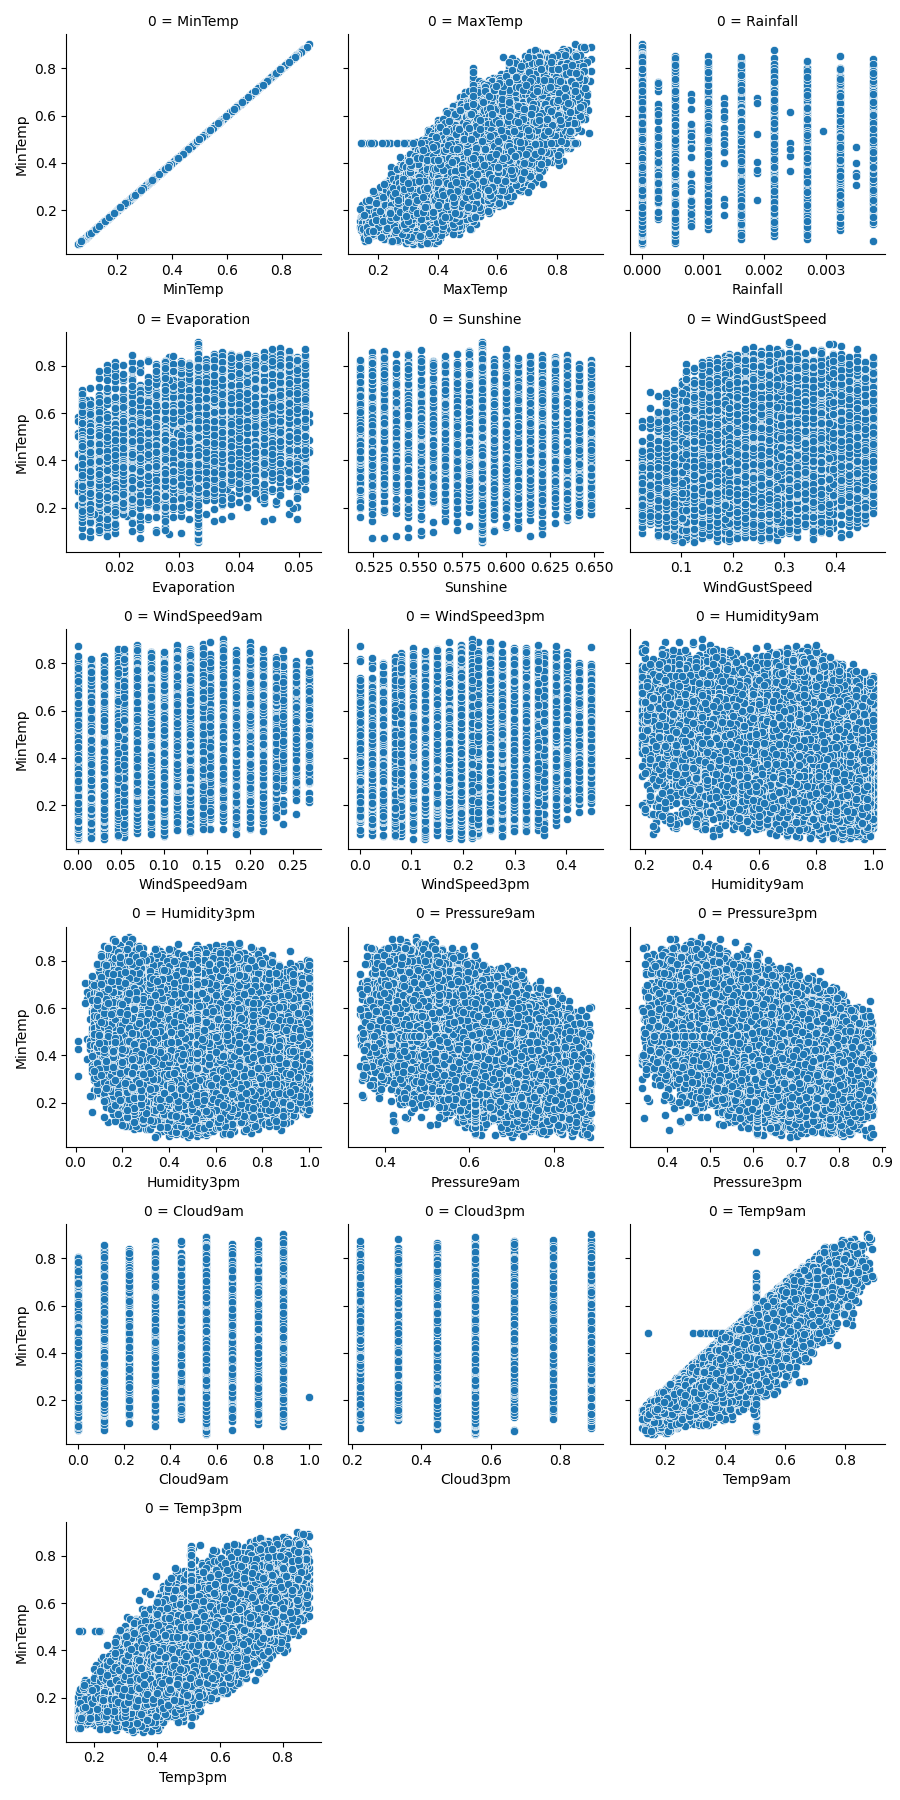

In [32]:
# https://stackoverflow.com/a/67853551
# https://stackoverflow.com/a/74662884
fig = sns.FacetGrid(pd.DataFrame(num_cols_ext_reg), col=0, col_wrap=3, sharex=False)

for ax, varx in zip(fig.axes, num_cols_ext_reg):
    sns.scatterplot(data=df_clean[num_cols_ext_reg], x=varx, y=target, ax=ax)
    
fig.tight_layout()

In [33]:
X = df_clean[num_cols_ext_reg].drop([target], axis=1)
y = df_clean[target]

In [34]:
# Разделение данных на train и test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_X, train_y)

y_pred = regr.predict(test_X)

max_len = 36
# Коэффициенты регрессии
print(f"Коэффициенты регрессии:\n{regr.coef_}")
# MSE
print(f"{'Средняя квадратичная ошибка (MSE):':<{max_len}} {MSE(test_y, y_pred):.3f}")
# MAE
print(f"{'Средняя абсолютная ошибка (MAE):':<{max_len}} {MAE(test_y, y_pred):.3f}")
# R2 score
print(f"{'Коэффициент детерминации (R2 score):':<{max_len}} {R2(test_y, y_pred):.3f}")

Коэффициенты регрессии:
[-0.05169886  5.12871612  0.05369974 -0.01381079  0.04866207  0.19345662
 -0.05372903  0.12158349  0.11582962 -0.30182429  0.28589264  0.03098874
 -0.01490015  1.02307958  0.1683743 ]
Средняя квадратичная ошибка (MSE):   0.003
Средняя абсолютная ошибка (MAE):     0.042
Коэффициент детерминации (R2 score): 0.862


In [35]:
df_features = pd.DataFrame(columns=X.columns, data=np.reshape(regr.coef_, (1, -1)))
df_features

,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,-0.051699,5.128716,0.0537,-0.013811,0.048662,0.193457,-0.053729,0.121583,0.11583,-0.301824,0.285893,0.030989,-0.0149,1.02308,0.168374


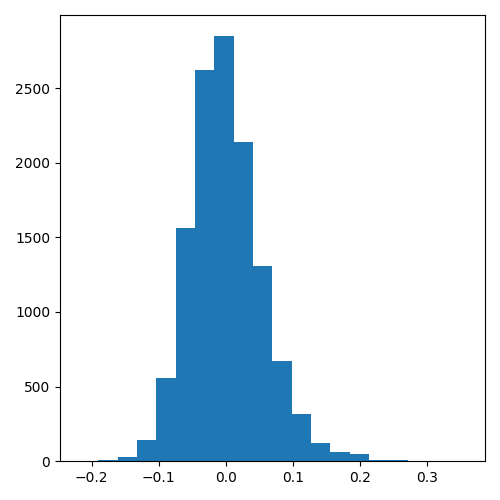

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(y_pred - test_y, bins=20)
fig.tight_layout()

### 5.11 Recursive Feature Elimination (RFE)

Источник:
- [Ранжирование признаков с помощью Recursive Feature Elimination в Scikit-Learn @ Хабр](https://habr.com/ru/companies/otus/articles/528676/)

Первым элементом, необходимым для рекурсивного исключения признаков (recursive feature elimination), является оценщик, например, линейная модель или дерево решений.  

У таких моделей есть коэффициенты для линейных моделей и важности признаков в деревьях решений. Для выбора оптимального количества признаков нужно обучить оценщика и выбрать признаки с помощью коэффициентов или значений признаков. Наименее важные признаки будут удаляться. Этот процесс будет повторяться рекурсивно до тех пор, пока не будет получено оптимальное число признаков.  

Мы используем [Pipeline](https://scikit-learn.org/stable/modules/compose.html) для преобразования данных. В `Pipeline` мы указываем $RFE$ для шага отбора признаков и модель, которая будет использоваться на следующем шаге.

In [37]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

# create pipeline
rfe = RFE(estimator=linear_model.LinearRegression(), n_features_to_select=7)
model = linear_model.LinearRegression()

rf_pipeline = Pipeline(steps=[('rfe', rfe), ('model', model)])
rf_pipeline.fit(train_X, train_y)

y_pred = rf_pipeline.predict(test_X)

max_len = 36
print(f"Выбранные признаки:\n{rf_pipeline.named_steps['rfe'].get_feature_names_out()}")
# Коэффициенты регрессии
print(f"Коэффициенты регрессии:\n{model.coef_}")
# MSE
print(f"{'Средняя квадратичная ошибка (MSE):':<{max_len}} {MSE(test_y, y_pred):.3f}")
# MAE
print(f"{'Средняя абсолютная ошибка (MAE):':<{max_len}} {MAE(test_y, y_pred):.3f}")
# R2 score
print(f"{'Коэффициент детерминации (R2 score):':<{max_len}} {R2(test_y, y_pred):.3f}")

Выбранные признаки:
['Rainfall' 'WindSpeed9am' 'Humidity3pm' 'Pressure9am' 'Pressure3pm'
 'Temp9am' 'Temp3pm']
Коэффициенты регрессии:
[ 8.3553854   0.13804477  0.21159471 -0.36671342  0.34730457  0.83825071
  0.28920088]
Средняя квадратичная ошибка (MSE):   0.003
Средняя абсолютная ошибка (MAE):     0.044
Коэффициент детерминации (R2 score): 0.853


In [38]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

# create pipeline
rfe = RFE(estimator=linear_model.LinearRegression(), n_features_to_select=7)

parameters = {'alpha': np.arange(0.01, 0.1, 0.01), 'l1_ratio': np.arange(0.01, 0.1, 0.01)}
elastic_net = linear_model.ElasticNet()

grid_search = GridSearchCV(elastic_net, parameters)

rf_pipeline = Pipeline(steps=[('rfe', rfe), ('model', grid_search)])
rf_pipeline.fit(train_X, train_y)

y_pred = rf_pipeline.predict(test_X)

max_len = 36
print(f"Выбранные признаки:\n{rf_pipeline.named_steps['rfe'].get_feature_names_out()}")
print(f"Параметры лучшей модели:\n{grid_search.best_params_}")
# Коэффициенты регрессии
print(f"Коэффициенты регрессии:\n{grid_search.best_estimator_.coef_}")
# MSE
print(f"{'Средняя квадратичная ошибка (MSE):':<{max_len}} {MSE(test_y, y_pred):.3f}")
# MAE
print(f"{'Средняя абсолютная ошибка (MAE):':<{max_len}} {MAE(test_y, y_pred):.3f}")
# R2 score
print(f"{'Коэффициент детерминации (R2 score):':<{max_len}} {R2(test_y, y_pred):.3f}")

Выбранные признаки:
['Rainfall' 'WindSpeed9am' 'Humidity3pm' 'Pressure9am' 'Pressure3pm'
 'Temp9am' 'Temp3pm']
Параметры лучшей модели:
{'alpha': 0.01, 'l1_ratio': 0.01}
Коэффициенты регрессии:
[ 0.          0.06623881  0.15061646 -0.08748665 -0.05565762  0.49060862
  0.27991722]
Средняя квадратичная ошибка (MSE):   0.005
Средняя абсолютная ошибка (MAE):     0.058
Коэффициент детерминации (R2 score): 0.761
